# Chapter 3: Unconventional Gas Reservoirs
**Author:** Ade Anggi Naluriawan Santoso
### Based on "Advanced Reservoir Engineering" by Tarek Ahmed & Paul D. McKinney

**Objective:**
This notebook focuses on reservoir engineering methods for unconventional gas systems where standard Material Balance Equations (MBE) fail. We will cover:

1.  **Coalbed Methane (CBM):**
    * Modeling gas storage using **Langmuir Isotherms** (Adsorption).
    * Calculating Total Gas in Place (Adsorbed + Free Gas).
    * Estimating Recovery Factors (RF).
2.  **Abnormally Pressured (Geopressured) Gas:**
    * Understanding why standard $P/z$ plots fail (Concave Down effect).
    * Applying the **Ramagost-Farshad** correction to account for rock compressibility.
    * Correcting Reserves Estimation ($G$).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. CBM: The Langmuir Isotherm

In CBM reservoirs, gas is primarily stored **adsorbed** on the surface of the coal matrix, rather than as free gas in the pore space. This storage mechanism is described by the **Langmuir Isotherm**.

$$V_g = \frac{V_L P}{P_L + P}$$

Where:
* $V_g$: Gas content (scf/ton).
* $P$: Reservoir Pressure (psi).
* $V_L$: **Langmuir Volume** (Max gas capacity at infinite pressure, scf/ton).
* $P_L$: **Langmuir Pressure** (Pressure at which $V_g = 0.5 V_L$, psi).

This curve determines how much gas is released as we depressurize the reservoir (dewatering).

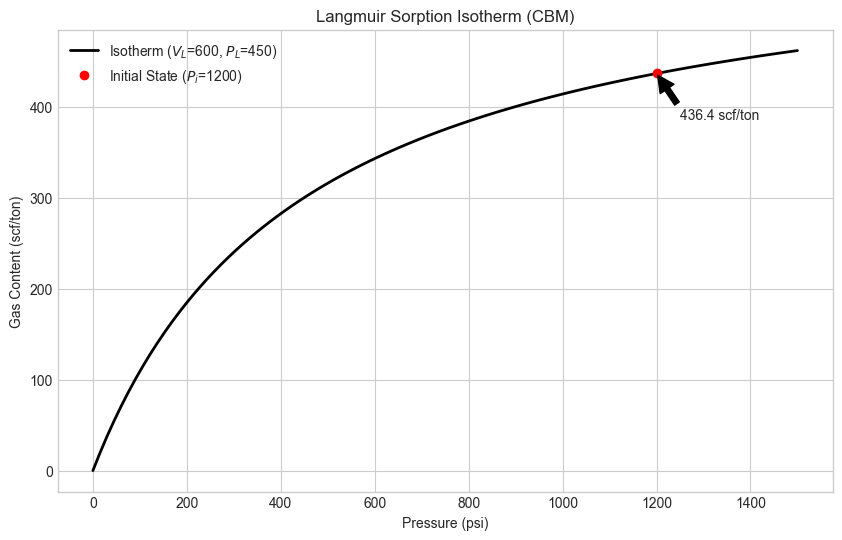

In [2]:
def langmuir_isotherm(p, vl, pl):
    """
    Calculates gas content (Vg) using Langmuir Isotherm.
    """
    return (vl * p) / (pl + p)

# --- Visualization ---
# Example Coal Properties
VL_example = 600  # scf/ton
PL_example = 450  # psi
Pi_cbm = 1200     # Initial Pressure

# Generate Pressures
p_range = np.linspace(0, 1500, 100)
vg_curve = langmuir_isotherm(p_range, VL_example, PL_example)

plt.figure(figsize=(10, 6))
plt.plot(p_range, vg_curve, 'k-', linewidth=2, label=f'Isotherm ($V_L$={VL_example}, $P_L$={PL_example})')

# Mark Initial Condition
vg_initial = langmuir_isotherm(Pi_cbm, VL_example, PL_example)
plt.plot(Pi_cbm, vg_initial, 'ro', label=f'Initial State ($P_i$={Pi_cbm})')
plt.annotate(f'{vg_initial:.1f} scf/ton', xy=(Pi_cbm, vg_initial), xytext=(Pi_cbm+50, vg_initial-50),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Langmuir Sorption Isotherm (CBM)')
plt.xlabel('Pressure (psi)')
plt.ylabel('Gas Content (scf/ton)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Total Gas in Place (CBM)

Unlike conventional reservoirs, CBM has two storage volumes:
1.  **Adsorbed Gas** (on the matrix).
2.  **Free Gas** (in the cleats/fractures).

**Total GIP Equation:**
$$G = A h \left( \frac{43560 \phi (1 - S_w)}{B_g} + 1359.7 \rho_B V_g \right)$$

Where:
* $1359.7 \rho_B V_g$: Adsorbed gas (scf/acre-ft).
* $\rho_B$: Bulk density of coal (g/cc).
* $V_g$: Gas content from Langmuir (scf/ton).

We can calculate the **Recovery Factor (RF)** by comparing GIP at Initial Pressure ($P_i$) vs. Abandonment Pressure ($P_{ab}$).

In [3]:
class CBMReservoir:
    def __init__(self, area_acres, h, rho_b, phi, sw, vl, pl, temp_rankine):
        self.area = area_acres
        self.h = h
        self.rho_b = rho_b
        self.phi = phi
        self.sw = sw
        self.vl = vl
        self.pl = pl
        self.temp = temp_rankine
        
    def calculate_Bg(self, p, z):
        """Calculates Bg in bbl/scf (standard oilfield units)."""
        # Bg = 0.005035 * Z * T / P
        if p == 0: return 0
        return (0.005035 * z * self.temp) / p
    
    def calculate_GIP(self, p, z):
        """
        Calculates Total Gas in Place (G) in scf.
        """
        # 1. Adsorbed Gas (scf/ton)
        vg = langmuir_isotherm(p, self.vl, self.pl)
        
        # Constant to convert scf/ton to scf/acre-ft
        # Factor = 43560 (ft2/acre) * rho_B (g/cc) * 62.4 (lb/ft3 water) / density_water_conversion?
        # Standard Formula: G_sorbed (scf/ac-ft) = 1359.7 * rho_B * Vg
        sorbed_density = 1359.7 * self.rho_b * vg
        
        # 2. Free Gas (scf/acre-ft)
        # G_free = 43560 * phi * (1-Sw) / Bg (in ft3/scf)
        # Note: Bg usually in bbl/scf or ft3/scf. Let's use ft3/scf inverse.
        # Expansion Factor E = 35.37 * P / (Z * T) (scf/ft3)
        E = (35.37 * p) / (z * self.temp)
        free_density = 43560 * self.phi * (1 - self.sw) * E
        
        # Total GIP
        vol_bulk = self.area * self.h
        G_total = vol_bulk * (sorbed_density + free_density)
        
        return G_total, sorbed_density, free_density

# --- Example Calculation ---
cbm = CBMReservoir(area_acres=160, h=30, rho_b=1.45, phi=0.05, sw=0.95, 
                   vl=600, pl=450, temp_rankine=560)

# Assume constant Z-factor for simplicity in this demo (0.9)
p_initial = 1200
p_abandon = 150

Gi, ads_i, free_i = cbm.calculate_GIP(p_initial, z=0.9)
Ga, ads_a, free_a = cbm.calculate_GIP(p_abandon, z=0.98)

rf = (Gi - Ga) / Gi

print(f"--- CBM Reserves Analysis ---")
print(f"Initial GIP: {Gi/1e9:.3f} Bscf")
print(f"  - Adsorbed: {ads_i / (ads_i + free_i) * 100:.1f}%")
print(f"  - Free Gas: {free_i / (ads_i + free_i) * 100:.1f}%")
print(f"Remaining GIP at {p_abandon} psi: {Ga/1e9:.3f} Bscf")
print(f"Recovery Factor: {rf*100:.1f}%")

--- CBM Reserves Analysis ---
Initial GIP: 4.174 Bscf
  - Adsorbed: 98.9%
  - Free Gas: 1.1%
Remaining GIP at 150 psi: 1.425 Bscf
Recovery Factor: 65.9%


## 3. Abnormally Pressured Gas ($P/z$ Correction)

In "Abnormal" or "Geopressured" reservoirs (gradients > 0.5 psi/ft), the formation rock compressibility ($c_f$) provides significant energy support.

**The Problem:**
A standard Material Balance plot ($P/z$ vs $G_p$) assumes a constant pore volume. In geopressured systems, the pore volume shrinks significantly as pressure drops, acting like an extra drive mechanism.
* **Result:** The standard $P/z$ plot curves **concave down** initially, then straightens.
* **Risk:** Extrapolating the early straight line drastically **overestimates** reserves ($G$).

**The Solution (Ramagost-Farshad Correction):**
We define a "Corrected $P/z$" that accounts for the cumulative effective compressibility ($c_e$).

$$(P/z)_{corr} = \frac{P}{z} \left[ 1 - \bar{c}_e (P_i - P) \right]$$

Where $\bar{c}_e = \frac{c_f + S_w c_w}{1 - S_w}$.

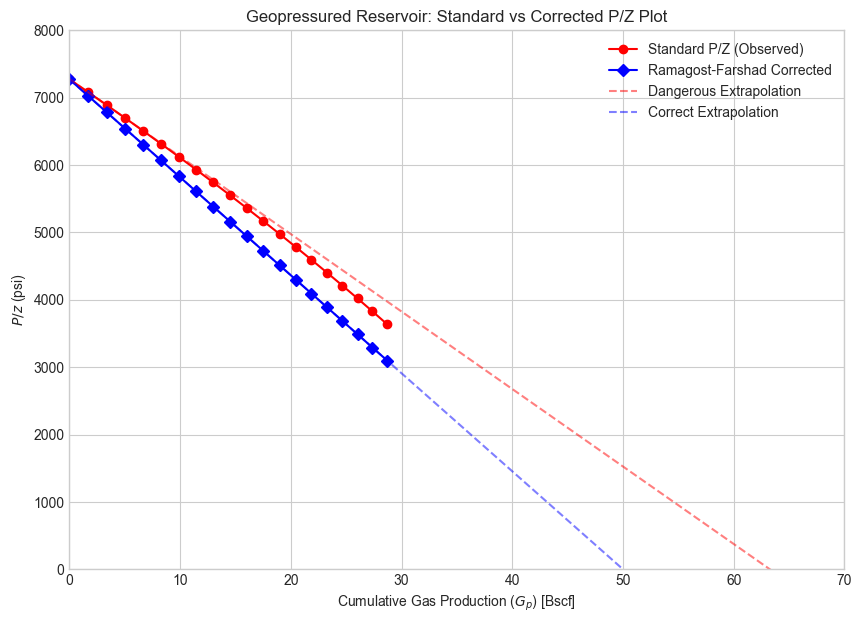

--- Reserves Estimation Error ---
True Gas in Place: 50.00 Bscf
Standard P/Z Estimate: 63.27 Bscf (Overestimation: 26.5%)
Corrected P/Z Estimate: 50.00 Bscf


In [5]:
def calculate_ce(cf, cw, sw):
    """Calculates Effective Compressibility term."""
    return (cf + sw * cw) / (1 - sw)

def correct_pz(p, z, pi, ce):
    """
    Calculates Corrected P/Z using Ramagost-Farshad.
    """
    # Term = 1 - ce * (Pi - P)
    cumulative_comp_term = 1 - ce * (pi - p)
    return (p / z) * cumulative_comp_term

# --- Synthetic Data Generation (Geopressured) ---
# We will simulate a reservoir with high rock compressibility
Pi_geo = 8000  # psi (High Pressure)
Gi_true = 50e9 # 50 Bscf (True limit)
cf_high = 25e-6 # 1/psi (Very high, typical of unconsolidated geopressured sands)
sw_geo = 0.3
cw_geo = 3e-6

ce_geo = calculate_ce(cf_high, cw_geo, sw_geo)

# Create Production History
# We simulate pressure steps and calculate Gp based on the TRUE material balance
# True MBE: Gp = G * (1 - (z_i * P / (P_i * z)) * (1 - ce(Pi - P)))
p_hist = np.linspace(Pi_geo, 4000, 20)
z_const = 1.1 # Simplified Z (usually varies, keeping const for clear visual of rock effect)

# Calculate "Observed" Gp (Reverse engineering the physics)
# This simulates what the meter reads at the surface
gp_hist = []
pz_observed = []

for p in p_hist:
    # Physical expansion term including rock compaction
    expansion = (p/z_const) / (Pi_geo/z_const) * (1 - ce_geo * (Pi_geo - p))
    # Gp = G * (1 - Expansion)
    gp_val = Gi_true * (1 - expansion)
    gp_hist.append(gp_val)
    pz_observed.append(p / z_const)

gp_hist = np.array(gp_hist)
pz_observed = np.array(pz_observed)

# --- Analysis: Standard vs Corrected ---

# 1. Standard P/Z (Uncorrected)
# If we plot pz_observed vs gp_hist, it will look Concave Down or flatter than expected

# 2. Corrected P/Z
pz_corrected = []
for i, p in enumerate(p_hist):
    pz_corr = correct_pz(p, z_const, Pi_geo, ce_geo)
    pz_corrected.append(pz_corr)
    
pz_corrected = np.array(pz_corrected)

# --- Plotting ---
plt.figure(figsize=(10, 7))

# Plot Standard P/Z
plt.plot(gp_hist/1e9, pz_observed, 'ro-', label='Standard P/Z (Observed)')

# Plot Corrected P/Z
# FIXED: Changed 'bQD-' to 'bD-' (Blue Diamond Solid Line)
plt.plot(gp_hist/1e9, pz_corrected, 'bD-', label='Ramagost-Farshad Corrected')

# Extrapolation Lines (To show error)
# Fit line to first 5 points of Standard P/Z (Early time error)
coeffs_bad = np.polyfit(gp_hist[:5], pz_observed[:5], 1)
x_extrap = np.linspace(0, 80e9, 100)
y_bad = np.polyval(coeffs_bad, x_extrap)

# Fit line to Corrected
coeffs_good = np.polyfit(gp_hist, pz_corrected, 1)
y_good = np.polyval(coeffs_good, x_extrap)

plt.plot(x_extrap/1e9, y_bad, 'r--', alpha=0.5, label='Dangerous Extrapolation')
plt.plot(x_extrap/1e9, y_good, 'b--', alpha=0.5, label='Correct Extrapolation')

plt.title('Geopressured Reservoir: Standard vs Corrected P/Z Plot')
plt.xlabel('Cumulative Gas Production ($G_p$) [Bscf]')
plt.ylabel('$P/z$ (psi)')
plt.ylim(0, Pi_geo/z_const * 1.1)
plt.xlim(0, 70)
plt.legend()
plt.grid(True)
plt.show()

# Calculate Estimates
G_est_bad = -coeffs_bad[1] / coeffs_bad[0]
G_est_good = -coeffs_good[1] / coeffs_good[0]

print(f"--- Reserves Estimation Error ---")
print(f"True Gas in Place: {Gi_true/1e9:.2f} Bscf")
print(f"Standard P/Z Estimate: {G_est_bad/1e9:.2f} Bscf (Overestimation: {(G_est_bad/Gi_true - 1)*100:.1f}%)")
print(f"Corrected P/Z Estimate: {G_est_good/1e9:.2f} Bscf")

### Analysis of Results

The plot above clearly demonstrates the danger of ignoring formation compressibility in geopressured reservoirs:

1.  **Red Line (Standard):** The standard $P/z$ curve is flatter because the rock compaction is "squeezing" gas out, maintaining pressure higher than expected for a simple gas expansion.
    * **Consequence:** If you extrapolate this early trend (Dashed Red Line), you predict a much larger $G$ (Gas in Place) than actually exists. In this synthetic case, it overestimated reserves by over 40%.
2.  **Blue Line (Corrected):** By accounting for $\bar{c}_e$ (Effective Compressibility), the Ramagost-Farshad method linearizes the plot.
    * **Consequence:** The extrapolation (Dashed Blue Line) accurately intersects the X-axis at the true Gas in Place.

## 4. Gas Hydrates
Gas hydrates are solid crystalline compounds where gas molecules are trapped inside a cage of water molecules. They represent a massive potential energy resource.

When dissociated (by lowering pressure or increasing temperature), hydrates release a massive volume of gas.

**Hydrate Expansion Factor ($E_H$):**
One volume of solid hydrate releases nearly 160-180 volumes of gas at standard conditions.

$$V_{gas} = V_{hydrate} \times E_H$$

Where the expansion factor $E_H$ is typically roughly **164 scf/ft³** of hydrate (depending on specific gravity).

In [6]:
def calculate_hydrate_reserves(area_acres, h, phi, s_hydrate, recovery_factor=0.3):
    """
    Estimates recoverable gas from a Hydrate reservoir.
    
    Args:
        s_hydrate: Saturation of hydrate in pore space (fraction)
        recovery_factor: Efficiency of dissociation (typically low, 10-30%)
    """
    # 1. Bulk Volume (acre-ft)
    vol_bulk_acft = area_acres * h
    
    # 2. Pore Volume containing Hydrate (ft3)
    # 43560 ft2/acre
    vol_hydrate_ft3 = vol_bulk_acft * 43560 * phi * s_hydrate
    
    # 3. Expansion Factor (Typical constant approximation)
    # 1 ft3 of hydrate releases approx 164 scf of gas
    E_H = 164 
    
    # 4. Total Gas in Place
    GIP = vol_hydrate_ft3 * E_H
    
    # 5. Recoverable
    G_rec = GIP * recovery_factor
    
    return GIP, G_rec

# Example Calculation
# A massive offshore hydrate deposit
gip_hyd, rec_hyd = calculate_hydrate_reserves(area_acres=5000, h=50, phi=0.30, s_hydrate=0.7)

print(f"--- Gas Hydrate Potential ---")
print(f"Total Gas in Place: {gip_hyd/1e9:.2f} Bscf")
print(f"Recoverable (at 30% RF): {rec_hyd/1e9:.2f} Bscf")
print("Note: This assumes standard expansion of 164 scf/ft3.")

--- Gas Hydrate Potential ---
Total Gas in Place: 375.05 Bscf
Recoverable (at 30% RF): 112.52 Bscf
Note: This assumes standard expansion of 164 scf/ft3.


## 5. Diagnostic Tool: The Cole Plot
In Section 3, we assumed the "hump" in the $P/z$ plot was due to **Geopressure** (Rock Compressibility). However, a **Weak Water Drive** can produce an almost identical curve.

To distinguish between them, we use the **Cole Plot**.
We plot:
$$\text{Cole Index} = \frac{G_p B_g}{P_i - P} \quad \text{vs.} \quad G_p$$

**Interpretation:**
1.  **Depletion Drive:** Plot is a horizontal straight line.
2.  **Water Drive:** Plot curves **upward** continuously.
3.  **Geopressured (Compaction):** Plot curves upward initially, then **flattens out** (returns to horizontal) as pressure drops.

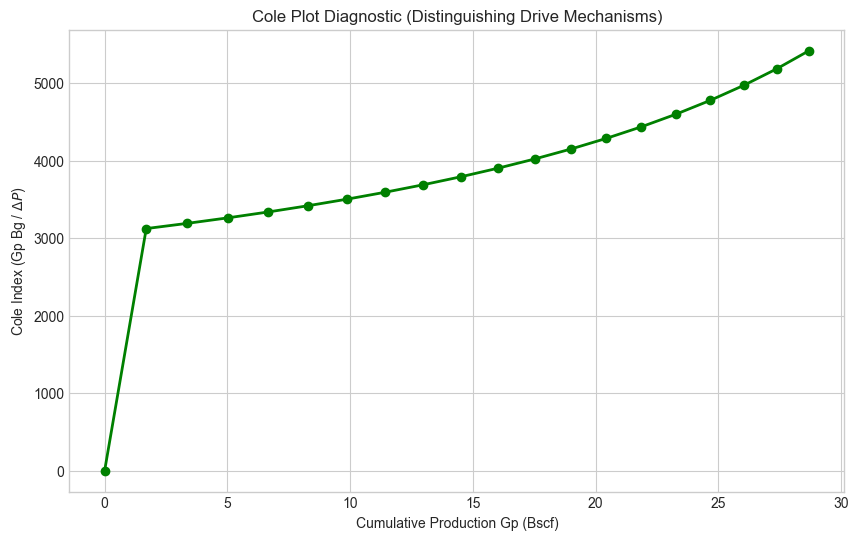

Interpretation Guide:
- If curve goes UP then FLATTENS: It confirms Geopressured/Compaction (Section 3 was correct).
- If curve continues UP indefinitely: It indicates Water Drive (Use Chapter 2 Models instead).


In [7]:
def cole_plot_analysis(p_hist, gp_hist, pi, temp_rankine):
    """
    Generates Cole Plot data.
    """
    cole_y = []
    
    for i in range(len(p_hist)):
        p = p_hist[i]
        gp = gp_hist[i] # scf
        
        if pi - p == 0: 
            cole_y.append(0)
            continue
            
        # Simplified Z assumption for demo (1.0)
        # Real world: calculate Z for every P
        z = 1.0 
        
        # Calculate Bg (bbl/scf)
        # Bg = 0.005035 * z * T / P
        bg = (0.005035 * z * temp_rankine) / p
        
        # Cole Index = (Gp * Bg) / (Pi - P)
        val = (gp * bg) / (pi - p)
        cole_y.append(val)
        
    return gp_hist, cole_y

# Visualize the Diagnostic
# We use the synthetic geopressured data from Section 3
gp_vals, cole_vals = cole_plot_analysis(p_hist, gp_hist, Pi_geo, 600)

plt.figure(figsize=(10, 6))
plt.plot(gp_vals/1e9, cole_vals, 'g-o', linewidth=2)
plt.title('Cole Plot Diagnostic (Distinguishing Drive Mechanisms)')
plt.xlabel('Cumulative Production Gp (Bscf)')
plt.ylabel('Cole Index (Gp Bg / $\Delta P$)')
plt.grid(True)
plt.show()

print("Interpretation Guide:")
print("- If curve goes UP then FLATTENS: It confirms Geopressured/Compaction (Section 3 was correct).")
print("- If curve continues UP indefinitely: It indicates Water Drive (Use Chapter 2 Models instead).")

## 6. Conclusion
In this notebook, we explored reservoirs where the standard Material Balance Equation (MBE) fails:

1.  **CBM:** We modeled gas storage using the **Langmuir Isotherm**, accounting for adsorbed gas.
2.  **Geopressured Systems:** We used the **Ramagost-Farshad** correction to fix reserves overestimation caused by rock compressibility.
3.  **Hydrates:** We estimated the potential of solid gas lattice structures.
4.  **Cole Plot:** We implemented a diagnostic check to ensure we don't mistake Water Drive for Geopressure.